# Conjugate Priors

*Notebook to implement conjugate prior evaluation on pymc3*

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as p
import pytensor.tensor as pt

from scipy import stats

In [2]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Normal distribution with known variance, unknown mean

$$
\sigma = 1\\
P(x|\Theta) \sim \mathcal{N}(\mu, \sigma^2) = \mathcal{N}(\mu, 1)\\
P(\theta | \Theta) \sim \mathcal{N}(\mu_0, \sigma_0^2)\\
P(\tilde{x}|\Theta') \sim \mathcal{N}(\frac{1}{\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}}(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^nx_i}{\sigma^2}), (\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2})^{-1})
$$

### Implement from scratch in python

In [21]:
n = 100
sigma = 1
unknown_mu = 0

Y = rng.normal(size = n, loc = unknown_mu, scale = sigma)
sample_mean = Y.mean()
sample_std = Y.std()

true_mean = np.power((1/np.power(sample_std, 2))+(n/np.power(sigma,2)), -1)*((sample_mean/np.power(sample_std, 2)) + (Y.sum()/np.power(sigma, 2)))
true_std = np.power((1 / np.power(sample_std, 2)) + (n/np.power(sigma, 2)), -1)

print(sample_mean)
print(sample_std)
print()

print(true_mean)
print(true_std)

0.03442462163753737
0.8446497033034687

0.03442462163753738
0.00986177022165975


### PyMC3 Implementation

In [11]:
with pm.Model() as m:
    mu = pm.Normal("mu", mu = unknown_mu, sigma = 30)
    obs = pm.Normal("obs", mu = mu, sigma = 30, observed = Y)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample())
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [mu, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Sampling: [obs]


Output()

In [13]:
print(true_mean, idata.posterior.mean().mu.values)

-1.972484208021451 -1.7447030276065372


## Normal with known mean $\mu$

$$
\mu = 0\\
P(x_i \| \theta) = \mathcal{N}(\mu, \sigma^2)\\
P(\theta \| \Theta) = \mathcal{N}(\nu, \sigma_0^2)\\
P(\theta \| \Theta') = \mathcal{N}(\nu + \eta, \frac{\nu \sigma_0^2 + \sum_{i=1}^n ( x_i - \mu)^2}{\nu + \eta})\\
P(\tilde{x} \| \Theta') = \mathcal{t}_{\nu'}(\tilde{x} \| \mu, \sigma_{0}^{2'})
$$

### Implemented from scratch

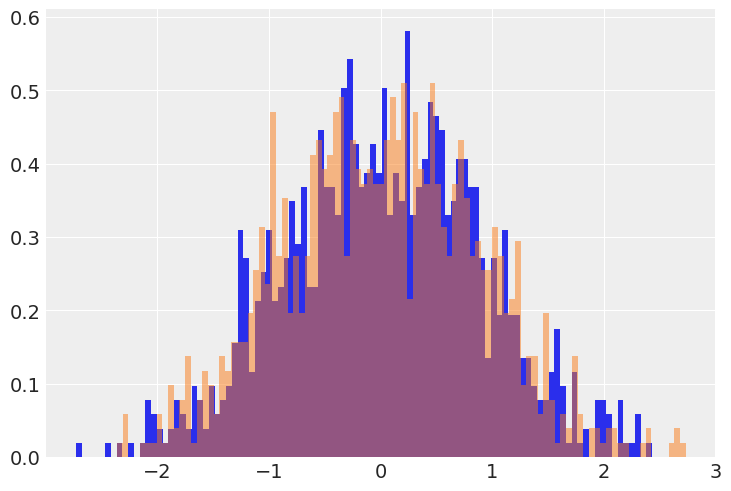

In [50]:
n = 1000
mu = 0
prior_alpha = 1
prior_beta = 1

X = stats.norm.rvs(loc = mu, scale = 0.9, size = n)

posterior_alpha = prior_alpha + n/2
posterior_beta = prior_beta + 0.5 * np.sum(np.power(X - mu, 2))

predictive = stats.t.rvs(posterior_alpha, loc = mu, scale = np.sqrt(posterior_beta/posterior_alpha), size = 1000)

plt.hist(predictive, bins = 100, density = True);
plt.hist(X, bins = 100, density = True, alpha = 0.5);

### PyMC3